### В данной домашней работе Вам предстоит отработать следующие 2 навыка: работа с пропущенными значениями и анализ выбросов.

In [1]:
import numpy as np
import pandas as pd

data = pd.read_csv('processed_data_with_new_features.csv', index_col='id')

In [2]:
data.head()

,vendor_id,passenger_count,store_and_fwd_flag,distance_km,log_trip_duration,anomaly,traffic_jam,day_of_week_1,day_of_week_2,day_of_week_3,...,hour_19,hour_20,hour_21,hour_22,hour_23,month_2,month_3,month_4,month_5,month_6
id,,,,,,,,,,,,,,,,,,,,,
id2875421,1,930.399753,0,1.500479,6.122493,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
id2377394,0,930.399753,0,1.807119,6.498282,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
id3858529,1,NaN,0,6.392080,7.661527,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
id3504673,1,NaN,0,1.487155,6.063785,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
id2181028,1,930.399753,0,1.189925,6.077642,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


Никудышный гном случайно пролил кофе на папку с данными и кодом. К несчастью, из-за этого они с братьями потеряли кучу информации в столбиках **passenger_count** и **distance_km**.

In [3]:
### Выведите количество пропусков в данных колонках
### На всякий случай, проверьте целостность данных в остальных

### Your code is here

print(data['distance_km'].isnull().sum(), data['passenger_count'].isnull().sum())

145864 145864


Начнем с **passenger_count**. Вообще говоря, изначально это была категориальная колонка, к которой мы применили технику OneHotEncoder. Чтобы избавиться от пропусков в данных, конечно, можно просто убрать все объекты, в которых есть пропуски, но тогда мы потеряем ценную информацию. 

Воспользуйтесь относительно простым приемом из лекции: в указанной колонке заполните пропуски самым *популярным* значением среди неотсутствующих.

In [4]:
### Your code is here
most_popular_passanger_count = round(data['passenger_count'].value_counts().index[0], 3)
data['passenger_count'] = data['passenger_count'].fillna(most_popular_passanger_count)

In [5]:
data['passenger_count'].isnull().sum()

0

С колонкой **distance_km** поступим более интересным способом!

Чтобы заполнить пропуск в данной колонке для того или иного объекта, можно находить наиболее похожий на него объект и подглядывать в его значение **distance_km**. Для того, чтобы понять, насколько объекты похожи друг на друга, необходимо использовать Евклидово расстояние между этими самыми объектами в пространстве всех признаков!

С учетом количества объектов в нашем датасете и признаков, посчитать попарные расстояния будет мега-сложно. Поэтому давайте называть объекты похожими, если они принадлежат одной категории, составленной из следующих колонок:

1. vendor_id
2. store_and_fwd_flag
3. traffic_jam
4. month_2
5. month_3
6. month_4
7. month_5
8. month_6

Внутри каждой группы найдите среднее значение признака **distance_km** и заполните NaN'ы в объектах с пропуском в соответствии с тем, к какой категории относится данный объект. Похожее упражнение мы делали на практике в занятии!

**Hint**: достаточно просто взять group by по указанным выше категориальным колонкам и верно вставить полученный результат в исходную табличку.

P.S. Колонки выбраны случайным образом. Можно было взять и другую комбинацию.

In [6]:
### Your code is here
grouped_means = data.groupby(["vendor_id",
"store_and_fwd_flag",
"traffic_jam",
"month_2",
"month_3",
"month_4",
"month_5",
"month_6"])['distance_km'].transform("mean")

data["distance_km"] = data["distance_km"].fillna(grouped_means)

In [7]:
### Убедимся, что пропусков не осталось

### Your code is here
print(data["distance_km"].isnull().sum())

data[:20].to_csv('HW_8_8_step.csv', index=False, sep=';')

0


### Теперь наши данные чисты! Замерьте качество модели на Кросс-Валидации

In [8]:
from sklearn.model_selection import KFold

selector = KFold(n_splits=4, shuffle=True, random_state=33)

from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression

### Your code is here
X = data.drop('log_trip_duration', axis=1)
y = data['log_trip_duration']

# X_train, X_test, y_train, y_test = train_test_split(X, y, 
#                                                     test_size=0.2, 
#                                                     random_state=42)

X_train = X
y_train = y

losses_train = []
losses_test = []


for train_index, test_index in selector.split(X_train):
    features_train, features_test = X_train.values[train_index], X_train.values[test_index]
    target_train, target_test = y_train.values[train_index], y_train.values[test_index]
    
    model = LinearRegression()
    model.fit(features_train, target_train)    ### Your code is here
    
    losses_train.append(np.mean((model.predict(features_train) - target_train)**2))
    # losses_test.append(np.mean((model.predict(features_test) - target_test)**2))
    
np.mean(losses_train).round(3)#, np.mean(np.array(losses_test)).round(3)

cross_val_error = np.mean(losses_train).round(3)

print(f"MSLE на Кросс-валидации: {round(cross_val_error, 3)}")



MSLE на Кросс-валидации: 0.43


In [8]:
from sklearn.model_selection import KFold

selector = KFold(n_splits=4, shuffle=True, random_state=33)

from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
### Your code is here
X = data.drop('log_trip_duration', axis=1)
y = data['log_trip_duration']

# X_train, X_test, y_train, y_test = train_test_split(X, y, 
#                                                     test_size=0.2, 
#                                                     random_state=42)

X_train = X
y_train = y

losses_train = []
losses_test = []


model = LinearRegression()
result = cross_validate(model, X, y, cv=selector, scoring = "neg_mean_squared_error")
cross_val_error = np.mean(result["test_score"])
print(f"MSLE на Кросс-валидации: {round(cross_val_error, 3)}")


MSLE на Кросс-валидации: -0.431


### Проведем анализ выбросов! Нарисуйте ящик с усами и гистограмму для таргетной переменной.

(array([1.53900e+03, 3.85400e+03, 4.02660e+04, 6.43870e+05, 7.33102e+05,
        3.39050e+04, 1.23000e+02, 1.98100e+03, 0.00000e+00, 4.00000e+00]),
 array([ 0.69314718,  2.13140795,  3.56966872,  5.0079295 ,  6.44619027,
         7.88445104,  9.32271181, 10.76097258, 12.19923336, 13.63749413,
        15.0757549 ]),
 <BarContainer object of 10 artists>)

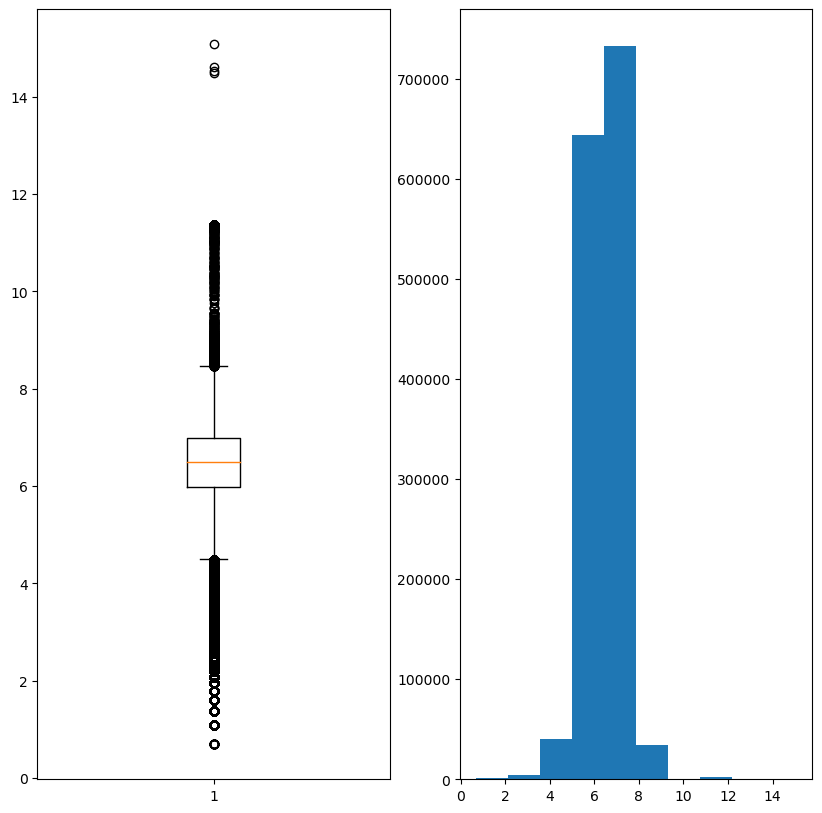

In [10]:
import matplotlib.pyplot as plt

### Your code is here
fig = plt.figure()
fig.set_size_inches(10, 10)
ax_3 = fig.add_subplot(1, 2, 1)
plt.boxplot(y)


ax_4 = fig.add_subplot(1, 2, 2)
plt.hist(y)

Есть ли, на ваш взгляд, в данных выбросы?

Кажется, что да!

Давайте почистим их, удалив те объекты, таргеты которых находятся вне промежутка

(топ 99,5% значение;   топ 0,5% значение)

In [11]:
### Your code is here
q_low = data['log_trip_duration'].quantile(0.005)
q_high = data['log_trip_duration'].quantile(0.995)

y_cleaned = data[(data['log_trip_duration'] > q_low) & (data['log_trip_duration'] < q_high)]["log_trip_duration"]

data_clean = data[(data['log_trip_duration'] > q_low) & (data['log_trip_duration'] < q_high)]


In [12]:
print(data_clean.shape, data.shape)

(1444013, 41) (1458644, 41)


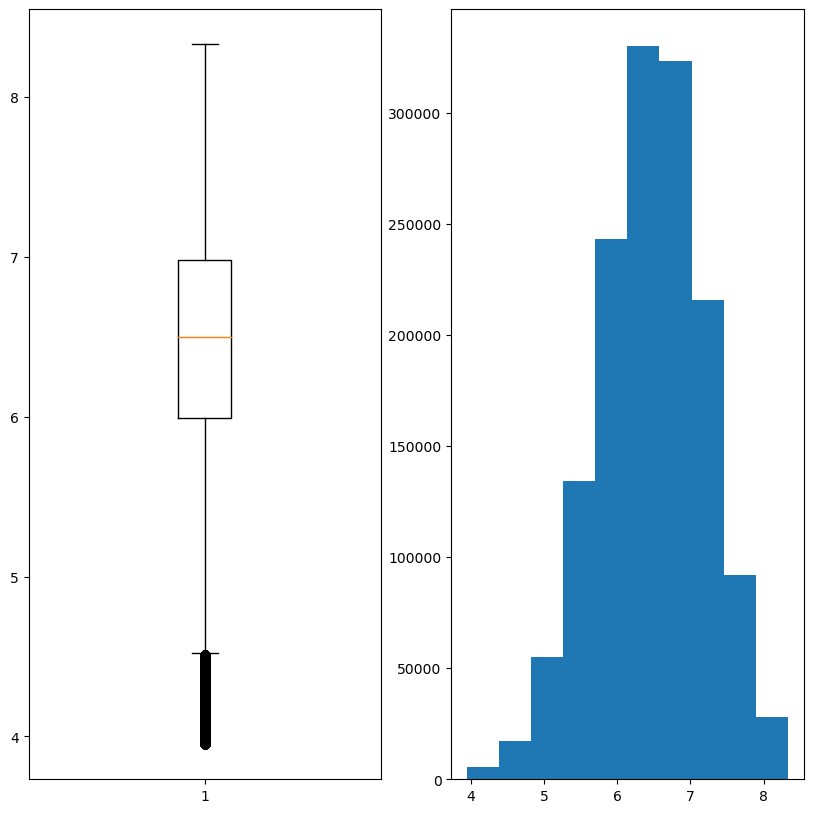

In [13]:
fig = plt.figure()
fig.set_size_inches(10, 10)
ax_3 = fig.add_subplot(1, 2, 1)
plt.boxplot(y_cleaned)


ax_4 = fig.add_subplot(1, 2, 2)
plt.hist(y_cleaned)

plt.show()

Снова замерьте качество на кросс-валидации, используя старый selector

In [14]:
### Your code is here

from sklearn.model_selection import KFold

selector = KFold(n_splits=4, shuffle=True, random_state=33)

from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression

### Your code is here
X = data_clean.drop('log_trip_duration', axis=1)
y = data_clean['log_trip_duration']

X_train = X
y_train = y

losses_train = []
losses_test = []


for train_index, test_index in selector.split(X_train):
    features_train, features_test = X_train.values[train_index], X_train.values[test_index]
    target_train, target_test = y_train.values[train_index], y_train.values[test_index]
    model = LinearRegression()
    model.fit(features_train, target_train)   
    losses_train.append(np.mean((model.predict(features_train) - target_train)**2))
    
np.mean(losses_train).round(3)

cross_val_error = np.mean(losses_train).round(5)

print(f"MSLE на Кросс-валидации: {round(cross_val_error, 5)}")



MSLE на Кросс-валидации: 0.33834


In [15]:
from sklearn.model_selection import KFold

selector = KFold(n_splits=4, shuffle=True, random_state=33)

from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression

### Your code is here
X = data_clean.drop('log_trip_duration', axis=1)
y = data_clean['log_trip_duration']

X_train = X
y_train = y

model = LinearRegression()
result = cross_validate(model, X, y, cv=selector, scoring = "neg_mean_squared_error")
cross_val_error = np.mean(result["test_score"])
print(f"MSLE на Кросс-валидации: {round(cross_val_error, 3)}")

MSLE на Кросс-валидации: -0.35
